<a href="https://colab.research.google.com/github/minassy/ISID_2021/blob/main/210919_%E3%83%A2%E3%83%87%E3%83%AA%E3%83%B3%E3%82%B0%E6%A4%9C%E8%A8%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/00_Competition/ISID/2021'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data', 'notebook']

In [3]:
DIR_DATA_TRAIN = os.path.join(DIR, 'data', 'Train_Unit_20210903')
DIR_DATA_TEST = os.path.join(DIR, 'data', 'Test_Unit_20210903')

In [4]:
#一連のデータ処理
def get_some_values(file_path):
  #ファイルパスから、ユニット名を取得。
  dirname = os.path.dirname(file_path)
  dirname_split = dirname.split('/')#区切り文字'/'で分割
  unit = dirname_split[-2]
  charge_mode = dirname_split[-1]
  #ファイルパスから、サイクル数を取得。
  basename = os.path.basename(file_path)
  basename_split = basename.split('_')[4]#区切り文字'_'で分割
  cycle_num = basename_split.split('.')[0]
  return unit, charge_mode, cycle_num

#%time
#DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
#C = 'Discharge'

def data_reading(DATA_DIR, C):

  #カラム名変更前後の辞書
  col_list = {'Time (s)' : 'Time',
              'Voltage Measured (V)' : 'VM',
              'Voltage Charge (V)' : 'VC',
              'Current Measured (Amps)' : 'CM', 
              'Current Charge (Amps)' : 'CC',
              'Temperature (degree C)': 'Temp', 
              'unit' : 'unit_name', 
              'charge_mode' : 'mode', 
              'Cycle_num' : 'Cycle',
              'Voltage Load (V)' : 'VL',
              'Current Load (Amps)' : 'CL'
  }

  df_list = []
  for folder in tqdm(os.listdir(DATA_DIR)[:3]):
    files = glob.glob(os.path.join(DATA_DIR, folder, C, '*.csv'))
    df_list_0 = []
    for file in files:
      tmp_df = pd.read_csv(file, encoding='utf-8')
      tmp_df = tmp_df.rename(columns=col_list)
      #ユニット名、充・放電モード、サイクル数の取得
      unit, charge_mode, cycle_num = get_some_values(file)
      #特徴量のデータフレームの作成
      if C == 'Charge':
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_c_vm' : featured_c_vm(tmp_df),
                          'feature_c_cm' : featured_c_cm(tmp_df),
                          'feature_c_vc' : featured_c_vc(tmp_df)}])
      else:
        df_exp = pd.DataFrame([{'unit':unit,
                          'charge_mode' : charge_mode,
                          'Cycle_num' : int(cycle_num),
                          'feature_d_vm' : featured_d_vm(tmp_df),
                          'feature_d_vl' : featured_d_vl(tmp_df)}])
      df_list_0.append(df_exp)
    df_0 = pd.concat(df_list_0)
    df_list.append(df_0)
  df = pd.concat(df_list)

  #ユニットとサイクルでソート。
  df = df.sort_values(['unit', 'Cycle_num'])
  #インデックスの振り直し
  df = df.reset_index(drop=True)

  return df

def featured_c_vm(df):
  #LAG=5が0.001未満が続くところを、飽和領域とみなす。
  p_c_vm = df.loc[:, 'VM'][df.loc[:, 'VM'].diff(5) < 0.001]
  #飽和領域のなかで、最初の点を点P_C_VMとする。
  p_c_vm = p_c_vm.reset_index(inplace=False)
  p_c_vm = p_c_vm['index'].iloc[0]
  #充電VMの特徴量は、点P_C_VMにおける時間
  feature_c_vm = df['Time'].loc[p_c_vm]
  return feature_c_vm

def featured_c_cm(df):
  #飽和領域からの立ち下がり点(LAG=5の勾配が最小となる点)を点P_C_CMとする。
  p_c_cm = np.gradient(df.loc[:, 'CM'].diff(5)[10:]).argmin()
  #充電CMの特徴量は、点P_C_CMにおける時間
  feature_c_cm = df['Time'].loc[p_c_cm]
  return feature_c_cm

def featured_c_vc(df):
  #VCが最大値を示す点を、点P_C_VCとする。
  p_c_vc = df.VC.argmax()
  #充電VCの特徴量は、点P_C_VCにおける時間
  feature_c_vc = df['Time'].loc[p_c_vc]
  return feature_c_vc

def featured_d_vm(df):
  #VMが最小値を示す点を、点P_D_VMとする。
  p_d_vm = df.VM.argmin()
  #放電VMの特徴量は、点P_D_VMにおける時間
  feature_d_vm = df['Time'].loc[p_d_vm]
  return feature_d_vm

def featured_d_vl(df):
  #VLの最大値点以降の領域において、最小値を示す点を、点P_D_VLとする。
  VL_max = df.VL.argmax()
  p_d_vl = df.VL[VL_max: ].argmin()
  #放電VLの特徴量は、点P_D_VLにおける時間
  feature_d_vl = df['Time'].loc[p_d_vl]
  return feature_d_vl

In [5]:
%time
#データの読み込み(学習)
#充電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_train_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

DATA_DIR = DIR_DATA_TRAIN
#DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_train_discharge = data_reading(DATA_DIR, C)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.39 µs


100%|██████████| 3/3 [01:17<00:00, 25.89s/it]


In [6]:
#充電と放電の特徴量のデータセット作成
df_train_feature = pd.merge(df_train_charge, df_train_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_train_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Train_Unit_1,Charge,1,3422.5,3207.4,3241.8,Discharge,3346.9,3327.2
1,Train_Unit_1,Charge,2,3431.6,3181.8,3262.3,Discharge,3328.8,3309.2
2,Train_Unit_1,Charge,3,3409.1,9692.7,3229.2,Discharge,3309.4,3289.8
3,Train_Unit_1,Charge,4,3407.7,3160.2,3228.2,Discharge,3309.7,3289.9
4,Train_Unit_1,Charge,5,3409.6,3172.4,3217.9,Discharge,3307.7,3287.9


In [7]:
%time
#データの読み込み(学習)
#充電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

C = 'Charge'
#C = 'Discharge'

df_test_charge = data_reading(DATA_DIR, C)

#データの読み込み(学習)
#放電

#DATA_DIR = DIR_DATA_TRAIN
DATA_DIR = DIR_DATA_TEST

#C = 'Charge'
C = 'Discharge'

df_test_discharge = data_reading(DATA_DIR, C)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


100%|██████████| 3/3 [00:41<00:00, 13.83s/it]


In [8]:
#充電と放電の特徴量のデータセット作成
df_test_feature = pd.merge(df_test_charge, df_test_discharge,
                            how = 'inner',
                            on = ['unit', 'Cycle_num'])
df_test_feature.head()

,unit,charge_mode_x,Cycle_num,feature_c_vm,feature_c_cm,feature_c_vc,charge_mode_y,feature_d_vm,feature_d_vl
0,Test_Unit_1,Charge,1,741.86,3476.3,3141.4,Discharge,3338.4,3328.9
1,Test_Unit_1,Charge,2,849.45,3451.6,3164.0,Discharge,3318.3,3308.8
2,Test_Unit_1,Charge,3,803.84,8280.7,3145.7,Discharge,3312.4,3302.7
3,Test_Unit_1,Charge,4,806.83,3102.9,3123.4,Discharge,3296.1,3286.4
4,Test_Unit_1,Charge,5,1004.50,3147.9,3163.0,Discharge,3298.1,3288.2


# モデリング

学習データ：X⇒trainのXXcycle、y⇒testのXXcylce
テストデータ：X⇒trainのXX以降のCycle、 y⇒予測

In [9]:
num_train_unit_1 = 124
num_train_unit_2 = 40
num_train_unit_3 = 97

num_test_unit_1 = 70
num_test_unit_2 = 12
num_test_unit_3 = 55

In [10]:
#学習データとテストデータ
train_unit_1 = df_train_feature[df_train_feature['unit'] == 'Train_Unit_1' ].reset_index()
test_unit_1 = df_test_feature[df_test_feature['unit'] == 'Test_Unit_1' ].reset_index()

テストユニット1_XGBoost

In [11]:
col_train = train_unit_1.columns[4:].drop(['charge_mode_y'])
train_X = train_unit_1[:num_test_unit_1][col_train]
train_y = test_unit_1[:num_test_unit_1]['feature_d_vm']

In [12]:
train_X.head()
train_y.head()

0    3338.4
1    3318.3
2    3312.4
3    3296.1
4    3298.1
Name: feature_d_vm, dtype: float64

In [13]:
col_test = train_unit_1.columns[4:].drop(['charge_mode_y'])
test_X = train_unit_1[num_test_unit_1:][col_test]
test_X.head()

,feature_c_vm,feature_c_cm,feature_c_vc,feature_d_vm,feature_d_vl
70,631.09,3072.4,2560.9,2916.1,2906.6
71,545.75,9730.6,2554.5,2896.8,2887.3
72,590.06,3273.4,2507.8,2888.2,2878.7
73,520.11,3408.9,2484.8,2879.3,2869.8
74,530.22,3713.3,2485.3,2859.7,2850.2


In [14]:
from xgboost import XGBRegressor

In [15]:
#モデルの作成
model = XGBRegressor(n_estimators=20, random_state=71)
model.fit(train_X,train_y)

[15:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=71,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [16]:
#テストデータの予測値を確率で出力
pred = model.predict(test_X)
pred

array([2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2605.9805, 2490.7053, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2605.9805, 2490.7053, 2605.9805, 2490.7053,
       2605.9805, 2605.9805, 2605.9805, 2490.7053, 2490.7053, 2490.7053,
       2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053, 2490.7053],
      dtype=float32)

XGBoostは、本タスクには向かなさそう。(変数とデータ数が少ないから？)

テストユニット1_線形回帰

In [17]:
from sklearn.linear_model import LinearRegression as LR

In [18]:
train_X = train_unit_1[:num_test_unit_1]['feature_d_vm'].values
train_y = test_unit_1[:num_test_unit_1]['feature_d_vm'].values

In [19]:
train_X = np.reshape(train_X, (-1, 1))
train_y = np.reshape(train_y, (-1, 1))

In [20]:
model_lr = LR()
model_lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

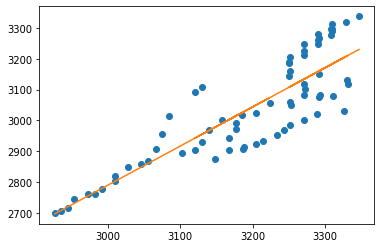

In [21]:
fig, ax = plt.subplots()

ax.plot(train_X, train_y, 'o')
ax.plot(train_X, model_lr.predict(train_X), linestyle="solid")

plt.show()

In [22]:
print('モデル関数の回帰変数 w1: %.3f' %model_lr.coef_)
print('モデル関数の切片 w2: %.3f' %model_lr.intercept_)
print('y= %.3fx + %.3f' % (model_lr.coef_ , model_lr.intercept_))
print('決定係数 R^2： ', model_lr.score(train_X, train_y))

モデル関数の回帰変数 w1: 1.271
モデル関数の切片 w2: -1022.966
y= 1.271x + -1022.966
決定係数 R^2：  0.7460659839610881


In [23]:
pred_values = 3500
pred_values = np.reshape(pred_values, (-1, 1))
model_lr.predict(pred_values)

array([[3425.16242126]])

In [24]:
test_X = train_unit_1[num_test_unit_1:]['feature_d_vm'].values
test_X = np.reshape(test_X, (-1, 1))
#test_X

In [25]:
#テストデータの予測
pred_test = model_lr.predict(test_X)
#pred_test

In [26]:
test_unit_1_70 = train_y
test_unit_1_pred = pred_test

In [54]:
test_unit_1 = np.concatenate([test_unit_1_70, test_unit_1_pred])
#test_unit_1

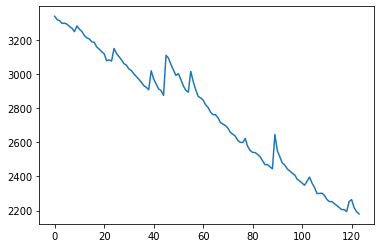

In [28]:
fig, ax = plt.subplots()

ax.plot(test_unit_1)

plt.show()

In [29]:
#ゴール(学習ユニットの故障時の到達点)
train_unit_1_min = np.min(train_unit_1['feature_d_vm'].values)
train_unit_1_min

2520.9

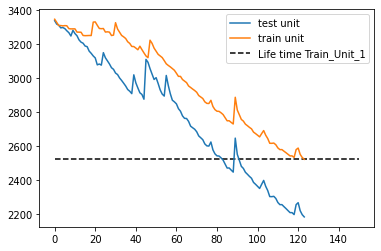

In [51]:
fig, ax = plt.subplots()

ax.plot(test_unit_1, label='test unit')
ax.plot(train_unit_1['feature_d_vm'], label='train unit')

plt.hlines(train_unit_1_min, 0, 150, linestyles='--', label='Life time Train_Unit_1')

plt.legend()
plt.show()

In [41]:
#回帰式
coef = model_lr.coef_
intercept = model_lr.intercept_
print('y=',coef,'x+',intercept)

y= [[1.2708939]] x+ [-1022.96621132]


In [34]:
#逆推定
print('x=','y-',model_lr.intercept_,'÷',model_lr.coef_)

x= y- [-1022.96621132] ÷ [[1.2708939]]


In [64]:
#テストユニットのデータセットを眺める
df_test_unit_1 = pd.DataFrame(test_unit_1, columns=['feature_d_vm'])
df_test_unit_1['Cycle'] = df_test_unit_1.index + 1
df_test_unit_1

,feature_d_vm,Cycle
0,3338.0,1
1,3318.0,2
2,3312.0,3
3,3296.0,4
4,3298.0,5
...,...,...
119,2253.0,120
120,2265.0,121
121,2217.0,122
122,2194.0,123


In [74]:
search_step = 5
search_min = train_unit_1_min - search_step
search_max = search_step + train_unit_1_min

In [78]:
lifetime_test_1 = df_test_unit_1.query('@search_min <= feature_d_vm <= @search_max')
lifetime_test_1 = lifetime_test_1['Cycle']
lifetime_test_1

83    84
Name: Cycle, dtype: int64